## Generate Drift Tar File for OpenScale Configuration

This notebook will generate the drift detection model file (tar.gz format), using the model training data and a model scoring function. The file can then be used during OpenScale configuration.

### Install specific versions of scikit-learn and ibm-wos-utils.  These versions are required for the drift model to run successfully.

In [1]:
#!pip install scikit-learn==0.20.2

In [2]:
#!pip install ibm-wos-utils==2.1.1

In [3]:
import pandas as pd

### Define Path to Training Data

#### Add the path of your "Airline_Virtualized_Data_Grp_number" dataset
- Go to the `Find and add data` icon, go to "Airline_Virtualized_Data_Grp_number.csv" dataset
- Select 'Insert to code' and then click on 'pandas Dataframe' as given in the screenshot below

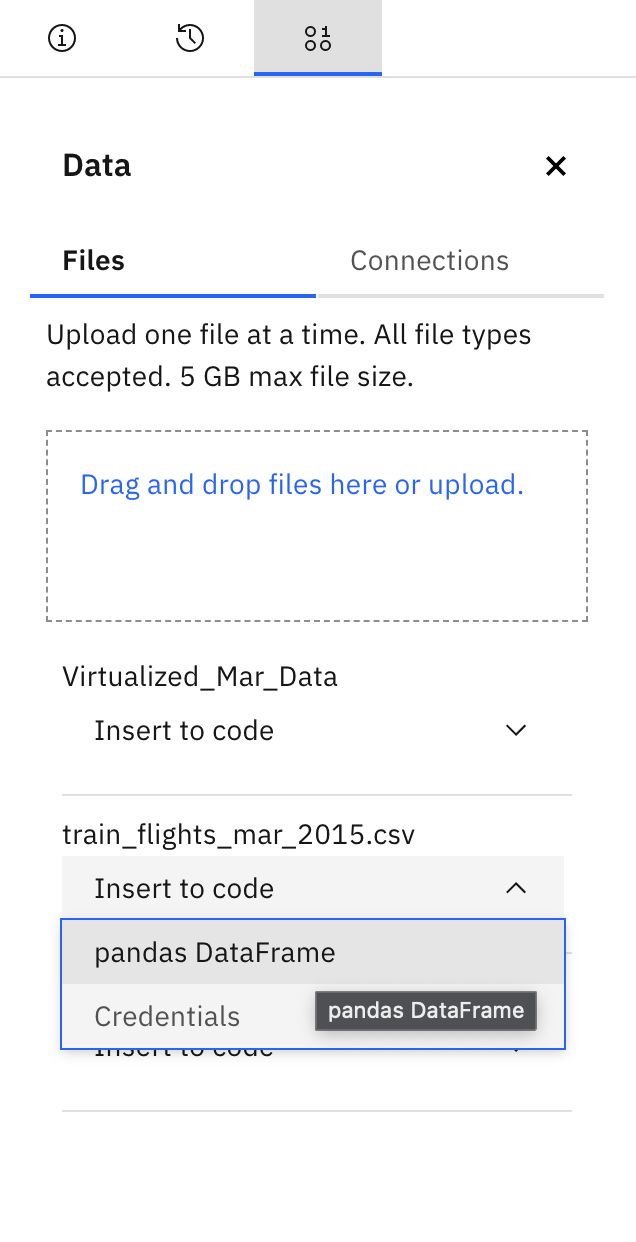

#### This will add the path of your dataset as given in the cell below

In [4]:
data_filepath = "/project_data/data_asset/Airline_Virtualized_Data_Grp_number_csv_1ev8vmlhh3wga43246hgfq3dc"

In [ ]:
df = pd.read_csv(data_filepath)
df.head()

### Extract Space and Deployment IDs

Go to the Navigation menu of your Cloud Pak for Data Platform, and select `Deployments` to view all your deployment spaces.

#### Extract "Pre_Prod_Deployment_`GroupNumber`" deployment space ID
- Open the "Pre_Prod_Deployment_`GroupNumber`" deployment space
- Go to the `Settings` tab and extract the `Space ID` as given in the screenshot below

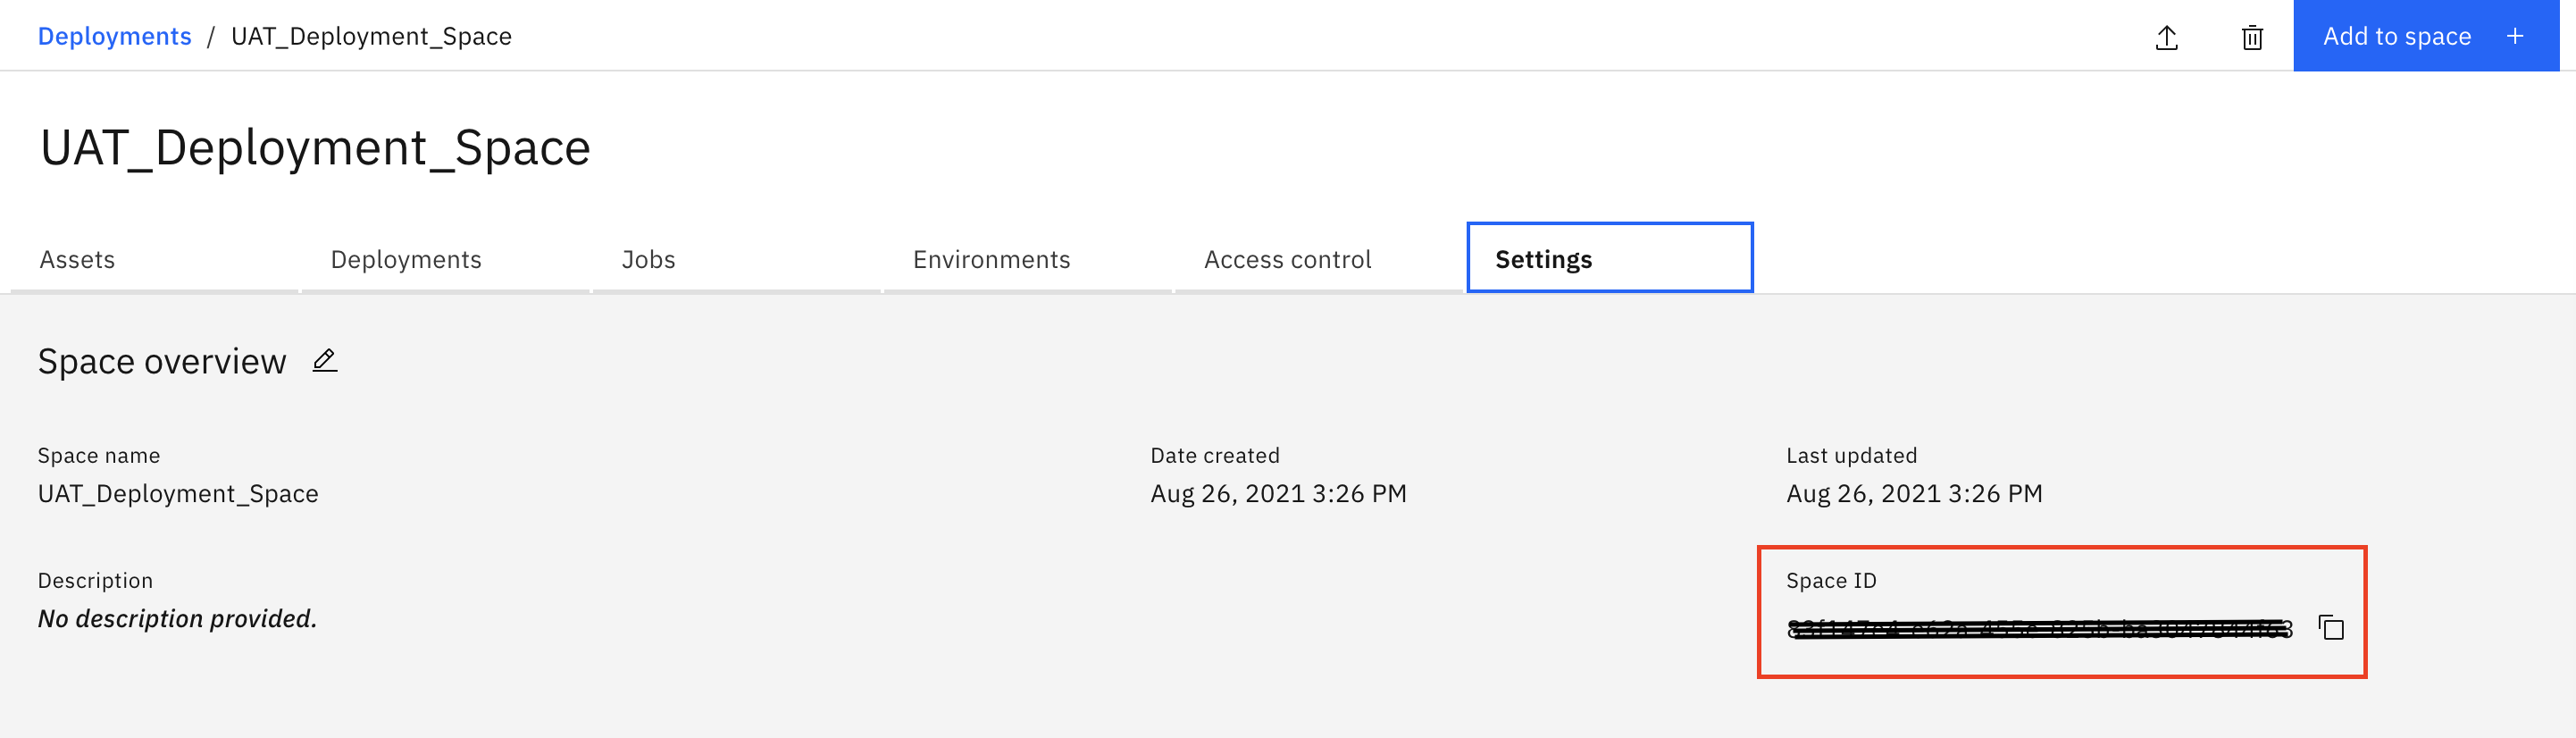

#### Extract "Model_Deployment_`GroupNumber`" deployment ID

- Go to the `Deployments` tab in the "Pre_Prod_Deployment_`GroupNumber`" deployment space
- Open the "Model_Deployment_`GroupNumber`" deployment
- Go to the `Deployment Info` icon and extract the `Deployment ID` as given in the screenshot below

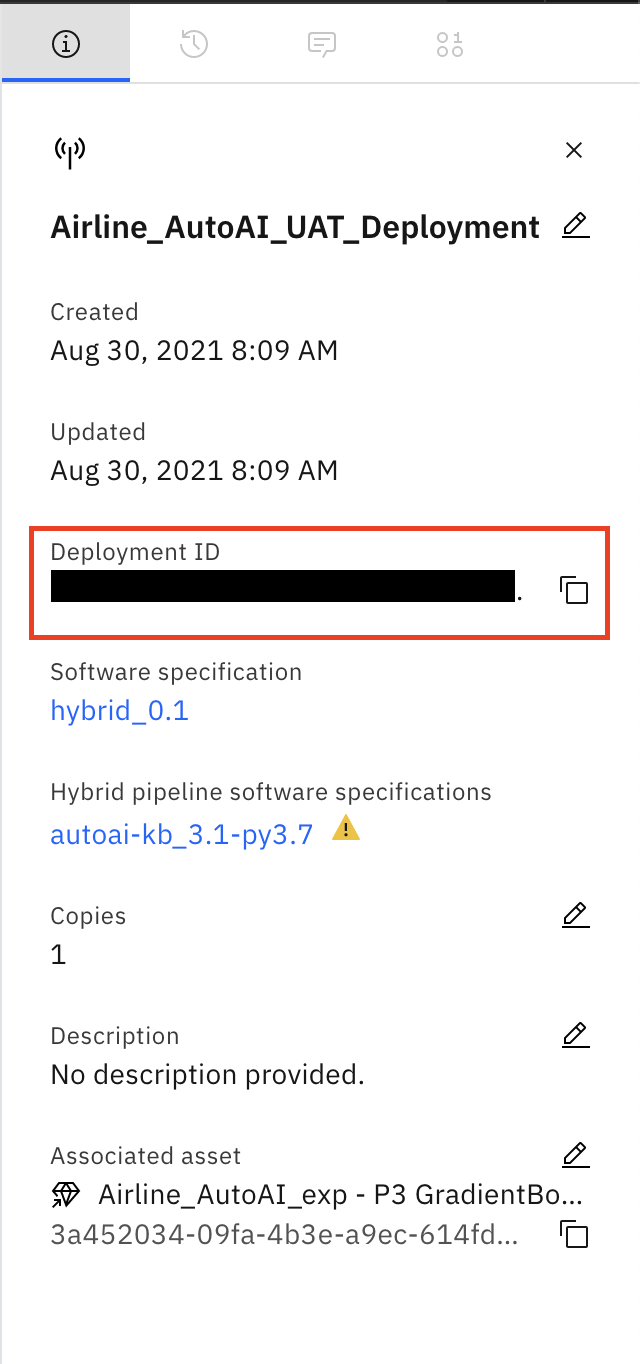

<br>

### Define Score Function
Drift model training requires a score function which scores the model endpoint and returns predictions/probabilities.  Below we define this function, with scoring happening via the wml_client.

#### Note: REPLACE `space_id` and `deployment_id` with the deployment space id and deployment id extracted in the previous step

In [24]:
def score(training_data_frame):
    import os
    WML_CREDENTAILS = {
       "token":os.environ['USER_ACCESS_TOKEN'],
       "instance_id" : "wml_local",
       "url": os.environ['RUNTIME_ENV_APSX_URL'],
       "version": "3.5"
     }
    # REPLACE VALUES BELOW TO MATCH YOUR DEPLOYMENT
    space_id = "space_id"
    deployment_id = "deployment_id"
    #The data type of the label column and prediction column should be same .
    #User needs to make sure that label column and prediction column array should have the same unique class labels
    prediction_column_name = "prediction"
    probability_column_name = "probability"

    
    feature_columns = list(training_data_frame.columns)
    training_data_rows = training_data_frame[feature_columns].values.tolist()

    from ibm_watson_machine_learning import APIClient 
    wml_client = APIClient(WML_CREDENTAILS)
    wml_client.set.default_space(space_id)

    payload_scoring = {
      wml_client.deployments.ScoringMetaNames.INPUT_DATA: [{
           "fields": feature_columns,
           "values": [x for x in training_data_rows]
      }]
    }

    score = wml_client.deployments.score(deployment_id, payload_scoring)
    score_predictions = score.get('predictions')[0]

    prob_col_index = list(score_predictions.get('fields')).index(probability_column_name)
    predict_col_index = list(score_predictions.get('fields')).index(prediction_column_name)

    if prob_col_index < 0 or predict_col_index < 0:
      raise Exception("Missing prediction/probability column in the scoring response")

    import numpy as np
    probability_array = np.array([value[prob_col_index] for value in score_predictions.get('values')])
    prediction_vector = np.array([value[predict_col_index] for value in score_predictions.get('values')])

    return probability_array, prediction_vector

In [ ]:
#score(df.head(1))

### Declare Label Column, Feature Columns, and Categorical Columns

In [14]:
label_column = "DELAYED"

In [21]:
categorical_columns = ["ORIGIN_AIRPORT","DESTINATION_AIRPORT","DAY_OF_WEEK","DAY"]
feature_cols = list(df.columns)
feature_cols.remove(label_column)

In [22]:
from ibm_wos_utils.drift.drift_trainer import DriftTrainer
import os

### Train Drift Model

In [25]:
drift_detection_input = {
    "feature_columns": feature_cols,
    "categorical_columns": categorical_columns,
    "label_column": label_column,
    "problem_type": 'binary'
}
    
drift_trainer = DriftTrainer(df, drift_detection_input)

# Note: Two column constraints are not computed beyond two_column_learner_limit(default set to 200)
# User can adjust the value depending on the requirement
drift_trainer.generate_drift_detection_model(score, batch_size=df.shape[0])
#drift_trainer.learn_constraints(two_column_learner_limit=200)
drift_trainer.learn_constraints(two_column_learner_limit=200, categorical_unique_threshold=0.5)
drift_trainer.create_archive()

Learning two feature constraints...: 100%|██████████| 30/30 [00:03<00:00,  8.98constraints/s]


### Store Drift tar.gz file 

In [ ]:
from shutil import copyfile
copyfile('drift_detection_model.tar.gz', '/project_data/data_asset/drift__model.tar.gz')

### Upload `drift_detection_model.tar.gz` file to Model_Catalog_`GroupNumber` Catalog

The previous step downloaded a `drift_detection_model.tar.gz` file on your local system. Upload this file into your "Model_Catalog_`GroupNumber`" catalog. 

- Go to the `Navigation Menu` -> `Catalogs` -> `All Catalogs`
- Open "Model_Catalog_`GroupNumber`" Catalog
- Click on `Add to Catalog` and select `Local files` as given in the screenshot below

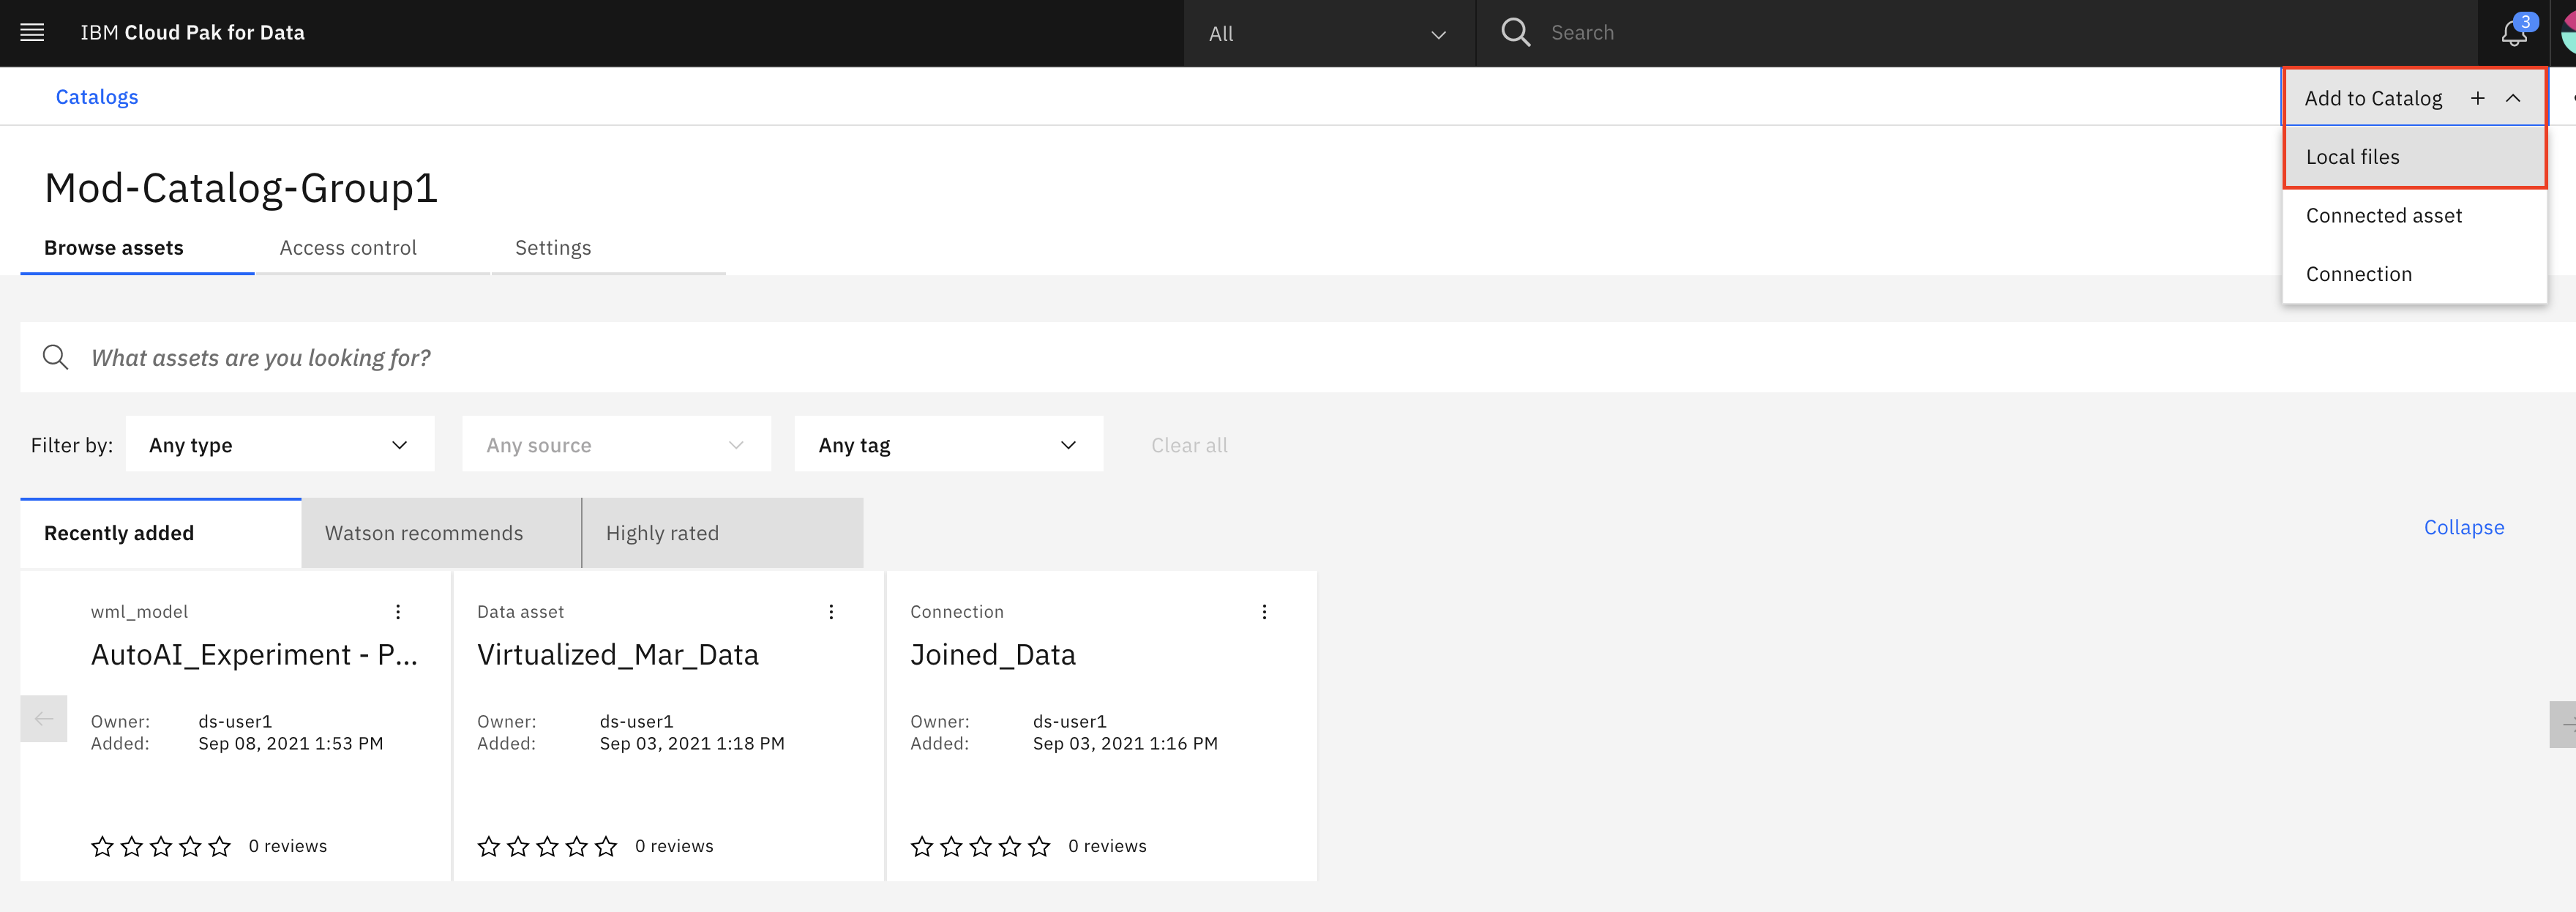

- Drag and drop the `drift_detection_model.tar.gz` file and click on `Add` in the bottom right as given in the screenshot below

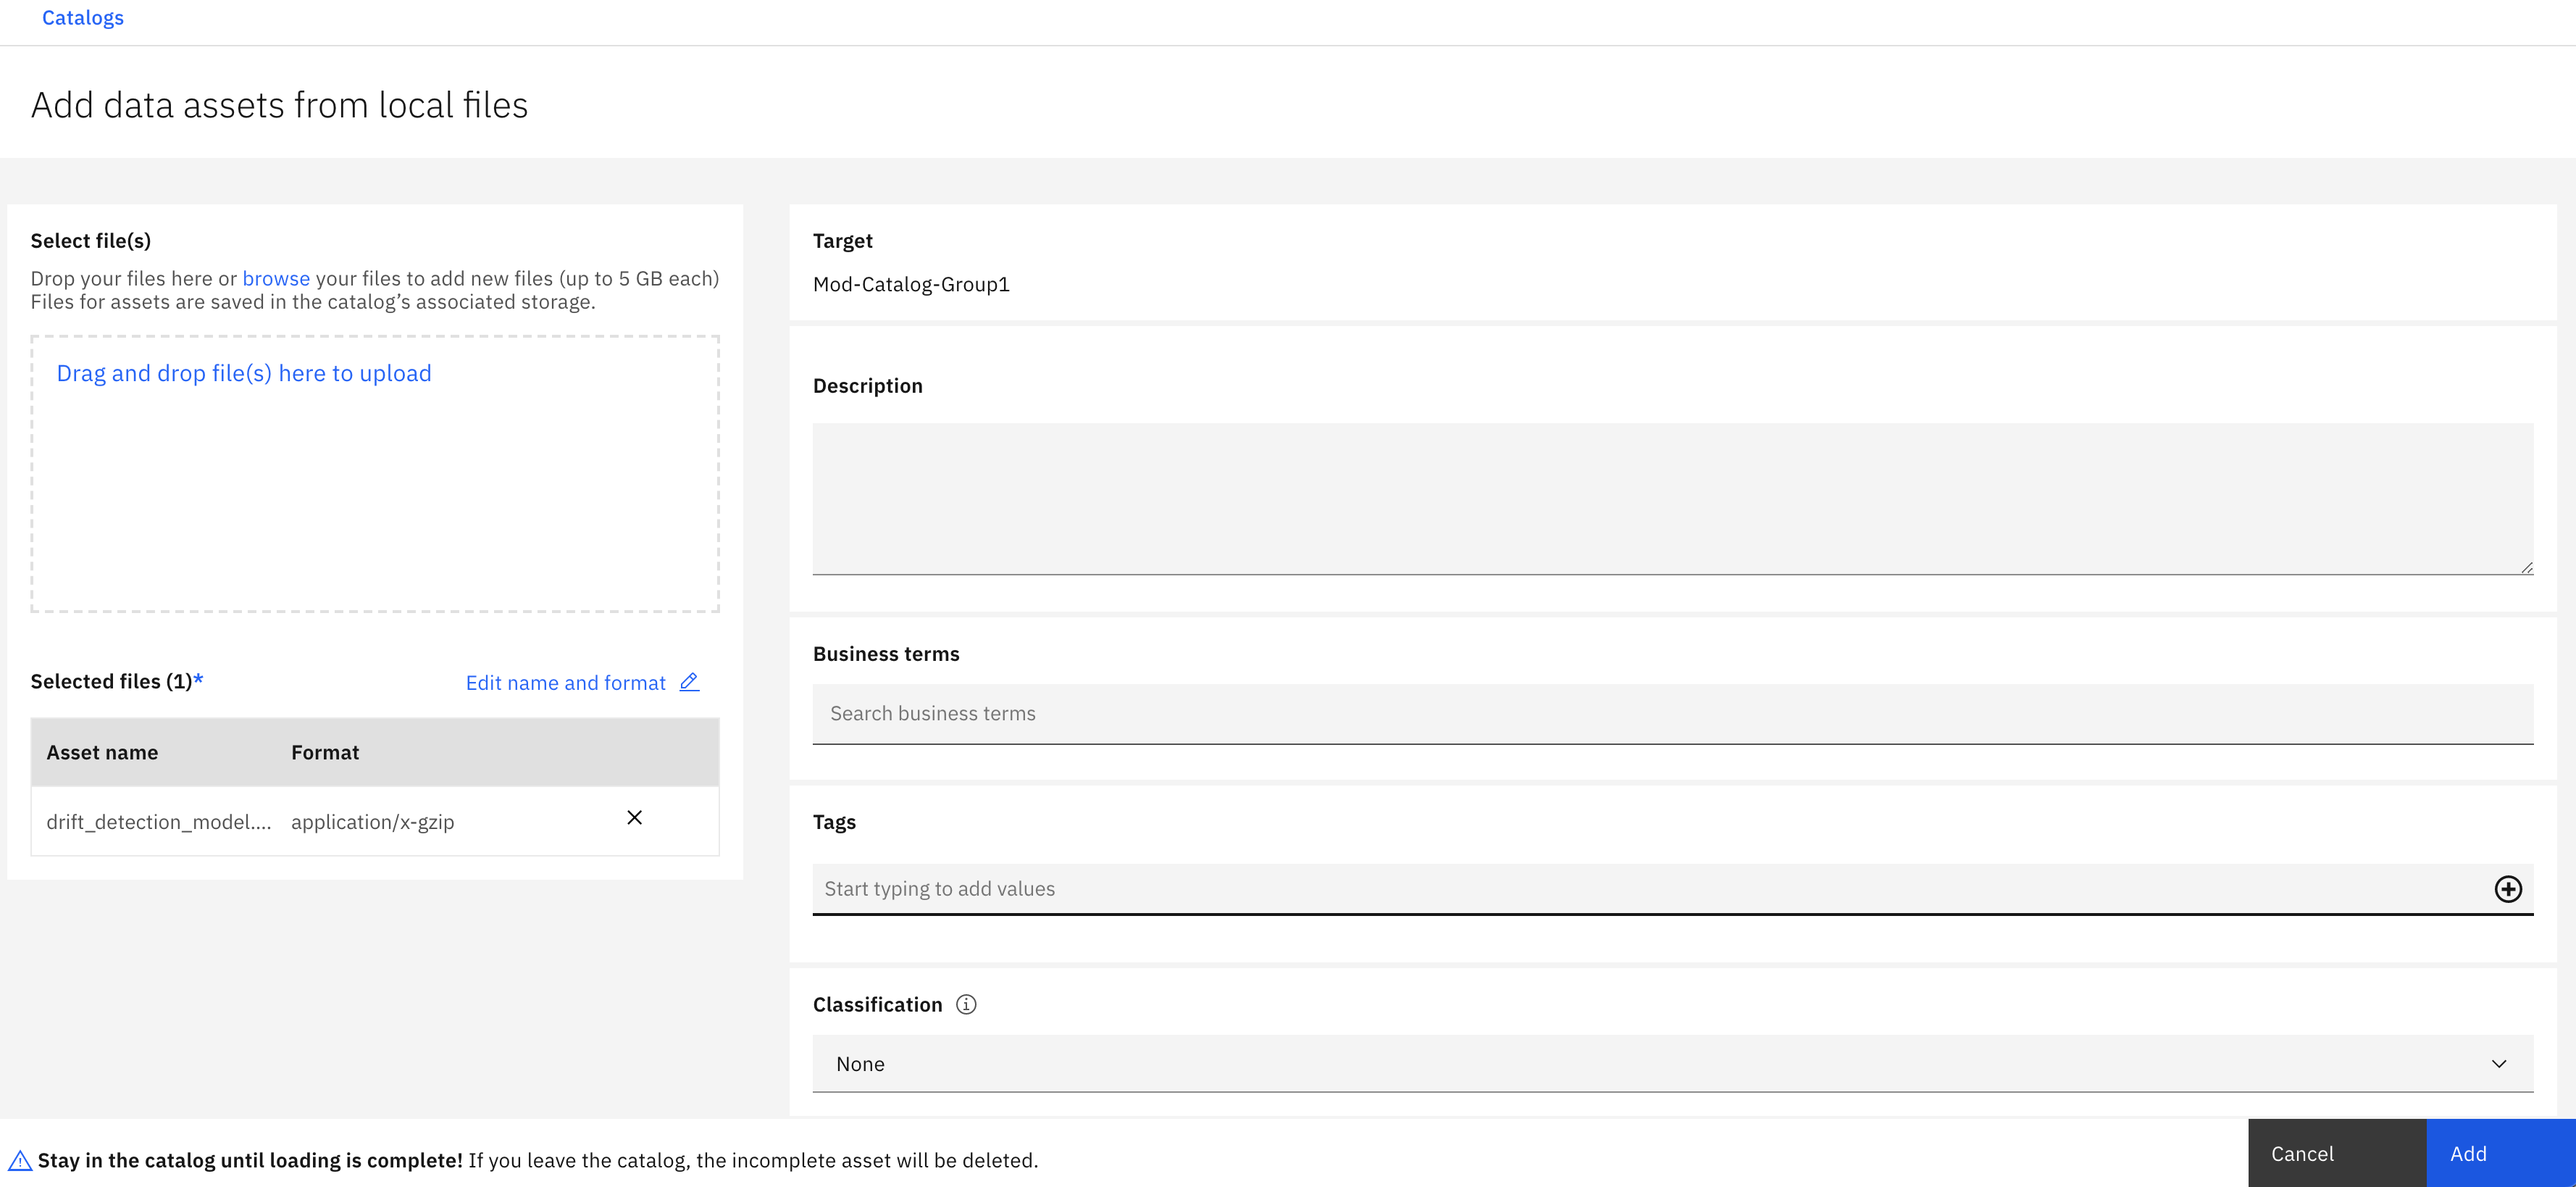

<br> 

- ##### Note: Stay in the catalog until loading is completed

Once the asset is loaded, You will be able to see the `drift_detection_model.tar.gz` file as a Data Asset in the `Browse Assets` section of the "Model_Catalog_`GroupNumber`" Catalog